## Face Recognition

This implementation is face recognition to identify peoples face.

Main idea is based on [FaceNet](https://arxiv.org/pdf/1503.03832.pdf).

This implementation is based on assignment 4 in Coursera (deeplearningai). 

Face recognition categorized into 2 problems.
- Face Verification: "Is this person is the claimed person?"
- Face Recognition: "Who is this person?"

FaceNet learns a neural network that encodes a face image into a vector of 128 numbers. 

By comparing two such vectors, you can then determine if two pictures are of the same person.

In this example, i will uses pre-trained model of FaceNet, consisting of inception modules.

(Caution) The filter representation is (# of samples, # of channel, Hight, Width).

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd

import shutil
import sys

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [2]:
!pip install tensorflow==1.15

In [0]:
import tensorflow as tf

In [166]:
from google.colab import drive
drive.mount ('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
!rm -R /content/Face-Recognition/

In [0]:
if 'Face-Recognition' not in 'content':
       !mkdir /content/Face-Recognition
       !cp -r /content/gdrive/My\ Drive/Face-Recognition/ /content/ 

In [7]:
os.listdir('/content/Face-Recognition')

['load_database.py',
 'train_test_file_for_pre_train',
 'requirment.sh',
 'face_recognition_model-june02.ipynb',
 'inception_blocks_v2.py',
 'fr_utils.py',
 'weights',
 'images',
 'ft_utils.ipynb']

In [0]:
os.chdir('/content/Face-Recognition/')
from fr_utils import *
from inception_blocks_v2 import *
from load_database import *

## 1 - Encoding face images into a 128-dimensional vector 

### 1.1 - Using an ConvNet  to compute encodings

The FaceNet model takes a lot of data and a long time to train. So following common practice in applied deep learning settings, let's just load weights that someone else has already trained. The network architecture follows the Inception model from [Szegedy *et al.*](https://arxiv.org/abs/1409.4842). 


- Sample image: (96x96x3) images (RGB). 
- Inputs: face image batch as a tenosor of shape $(m, n_C, n_H, n_W) = (m, 3, 96, 96)$ 
- Outputs: a matrix of shape $(m, 128)$ .  128-d embeding vectors.

Run the cell below to create the model for face images.

In [9]:
FRmodel = faceRecoModel(input_shape=(3, 96, 96))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [10]:
print("Total Params:", FRmodel.count_params())

Total Params: 3743280


** Expected Output **
<table>
<center>
Total Params: 3743280
</center>
</table>




### 1.2 - The Triplet Loss



Training will use triplets of images $(A, P, N)$:  

- A is an "Anchor" image--a picture of a person. 
- P is a "Positive" image--a picture of the same person as the Anchor image.
- N is a "Negative" image--a picture of a different person than the Anchor image.

These triplets are picked from our training dataset. We will write $(A^{(i)}, P^{(i)}, N^{(i)})$ to denote the $i$-th training example. 

You'd like to make sure that an image $A^{(i)}$ of an individual is closer to the Positive $P^{(i)}$ than to the Negative image $N^{(i)}$) by at least a margin $\alpha$:

$$\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2 + \alpha < \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2$$

You would thus like to minimize the following "triplet cost":

$$\mathcal{J} = \sum^{m}_{i=1} \large[ \small \underbrace{\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2}_\text{(1)} - \underbrace{\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2}_\text{(2)} + \alpha \large ] \small_+ \tag{3}$$

Here, we are using the notation "$[z]_+$" to denote $max(z,0)$.  

Notes:
- The term (1) is the squared distance between the anchor "A" and the positive "P" for a given triplet; you want this to be small. 
- The term (2) is the squared distance between the anchor "A" and the negative "N" for a given triplet, you want this to be relatively large, so it thus makes sense to have a minus sign preceding it. 
- $\alpha$ is called the margin. It is a hyperparameter that you should pick manually. We will use $\alpha = 0.2$. 

Most implementations also normalize the encoding vectors  to have norm equal one (i.e., $\mid \mid f(img)\mid \mid_2$=1); you won't have to worry about that here.

In [0]:
# GRADED FUNCTION: triplet_loss

def triplet_loss(y_true, y_pred, alpha = 0.2):
    """x
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    pos_dist = tf.reduce_sum(tf.square(anchor-positive),axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor-negative),axis=-1) 
    basic_loss = pos_dist - neg_dist + alpha
    loss = tf.maximum(0.0,basic_loss)
    
    return loss

In [12]:
with tf.Session() as test:
    tf.set_random_seed(1)
    y_true = (None, None, None)
    y_pred = (tf.random_normal([3, 128], mean=6, stddev=0.1, seed = 1),
              tf.random_normal([3, 128], mean=1, stddev=1, seed = 1),
              tf.random_normal([3, 128], mean=3, stddev=4, seed = 1))
    loss = triplet_loss(y_true, y_pred)
    
    print("loss = " + str(sum(loss.eval())))

loss = 528.142578125


**Expected Output**:

<table>
    <tr>
        <td>
            **loss**
        </td>
        <td>
           528.143
        </td>
    </tr>

</table>

## 2 - Loading the trained model

FaceNet is trained by minimizing the triplet loss. But since training requires a lot of data and a lot of computation, we won't train it from scratch here. Instead, we load a previously trained model. Load a model using the following cell; this might take a couple of minutes to run. 

load_weights_from_FaceNet function is implmented in 'fr_utils.py'

In [0]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

## 3 - Applying the model

Build a **Face verification** system so as to only let people from a specified list come in. 

To get admitted, each person has to swipe an ID card (identification card) to identify themselves at the door. 

The face recognition system then checks that they are who they claim to be. 

### 3.1 - Face Verification

Let's build a database containing one encoding vector for each person allowed to enter the happy house. To generate the encoding we use `img_to_encoding(image_path, model)` which basically runs the forward propagation of the model on the specified image. 

Run the following code to build the database (represented as a python dictionary). This database maps each person's name to a 128-dimensional encoding of their face.

In [0]:
def resize_image(path,file,IMG_SIZE,ind_gen,order):
    """
    ind_gen=0 No saved image to disk
    ind_gen=1 save image to disk
    order='first' or 'last'
    """
    if file=='':
        imagePath=path
    else:
        imagePath=os.path.join(path,file) 
    image = io.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE,IMG_SIZE))    
    if ind_gen==1:
            cv2.imwrite(file,image)
            if order=='first':
              image=np.rollaxis(image,axis=2,start=0)
            return file,image
    else:
        if order=='first':
              image=np.rollaxis(image,axis=2,start=0)
        return _,image 

In [77]:
from skimage import io
path='/content/Face-Recognition/images/'
path_new='/content/Face-Recognition/images96/'
if 'images96' not in os.listdir('/content/Face-Recognition'):
          os.mkdir(path_new)
else:
    for f in os.listdir(path_new):
        os.remove(path_new + f)
for f in os.listdir(path):
    if f.split('.')[-1]!='gif':
        
        f,x=resize_image(path,f,96,1,'first')
        print(f,x.shape)
        shutil.move(f,path_new)

emmy-noether.jpg (3, 96, 96)
Bernhard-Riemann.jpg (3, 96, 96)
Leonardo-Fibonacci-Bigollo.jpg (3, 96, 96)
Tao.jpg (3, 96, 96)
Wilhelm-Leibniz.jpg (3, 96, 96)
Felix-Klein.jpeg (3, 96, 96)
Srinivasa-Ramanujan.jpg (3, 96, 96)
Andrey-Kolmogorov.jpeg (3, 96, 96)
Sir-Isaac-Newton.jpg (3, 96, 96)
Carl_Friedrich_Gauss.jpg.838x0_q80.jpg (3, 96, 96)
JosephLouisLagrange.jpg (3, 96, 96)
David-Hilbert.jpeg (3, 96, 96)
Nicolaus-Copernicus.jpeg (3, 96, 96)
Vladimir-Arnold.jpeg (3, 96, 96)
Pafnuty-Chebishev.jpeg (3, 96, 96)
maria-gaetana-agnesi.jpg (3, 96, 96)
bhaskar.jpg (3, 96, 96)
JohnvonNeumann.jpg.838x0_q80.jpg (3, 96, 96)
Hualuogeng.jpg (3, 96, 96)
euphemia-haynes.jpg (3, 96, 96)
isaac-newton.jpg (3, 96, 96)
hypatia.jpg (3, 96, 96)
CHristiaan-Huygens.jpeg (3, 96, 96)
Rene-Descartes.jpeg (3, 96, 96)
Loo-Ken-Hua.jpeg (3, 96, 96)
Leonid-Kantorovich.jpeg (3, 96, 96)
Albert-Einstein.jpeg (3, 96, 96)
Hellenestic-Arquimedes.jpeg (3, 96, 96)
marjorie-lee-browne.jpg (3, 96, 96)
brahmagupta.jpg (3, 96, 96)

In [78]:
len(os.listdir(path_new)), len(os.listdir(path))

(60, 61)

In [0]:
path_list=["images96/"+ f for f in os.listdir(path_new)]

In [84]:
path_list

['images96/emmy-noether.jpg',
 'images96/Bernhard-Riemann.jpg',
 'images96/Leonardo-Fibonacci-Bigollo.jpg',
 'images96/Tao.jpg',
 'images96/Wilhelm-Leibniz.jpg',
 'images96/Felix-Klein.jpeg',
 'images96/Srinivasa-Ramanujan.jpg',
 'images96/Andrey-Kolmogorov.jpeg',
 'images96/Sir-Isaac-Newton.jpg',
 'images96/Carl_Friedrich_Gauss.jpg.838x0_q80.jpg',
 'images96/JosephLouisLagrange.jpg',
 'images96/David-Hilbert.jpeg',
 'images96/Nicolaus-Copernicus.jpeg',
 'images96/Vladimir-Arnold.jpeg',
 'images96/Pafnuty-Chebishev.jpeg',
 'images96/maria-gaetana-agnesi.jpg',
 'images96/bhaskar.jpg',
 'images96/JohnvonNeumann.jpg.838x0_q80.jpg',
 'images96/Hualuogeng.jpg',
 'images96/euphemia-haynes.jpg',
 'images96/isaac-newton.jpg',
 'images96/hypatia.jpg',
 'images96/CHristiaan-Huygens.jpeg',
 'images96/Rene-Descartes.jpeg',
 'images96/Loo-Ken-Hua.jpeg',
 'images96/Leonid-Kantorovich.jpeg',
 'images96/Albert-Einstein.jpeg',
 'images96/Hellenestic-Arquimedes.jpeg',
 'images96/marjorie-lee-browne.jpg'

In [85]:
database = load_database(path_list, FRmodel)

In [92]:
print(database['Bernhard-Riemann'])

[[ 7.54176006e-02  1.22373782e-01  5.98774627e-02 -9.57251713e-02
   1.40758619e-01  1.34775773e-01  2.82476973e-02  8.81923479e-04
  -1.60740897e-01  8.15270990e-02  2.69684428e-03  1.83656644e-02
   7.61885941e-02  4.31995429e-02  1.68509349e-01 -7.41939386e-03
   2.77249720e-02 -3.25615797e-03 -2.28995513e-02  1.60884127e-01
  -1.04535306e-02  7.70559236e-02  9.76956412e-02  6.87592551e-02
  -3.55317183e-02 -7.82359615e-02 -8.66301134e-02 -6.16882648e-03
   1.65907726e-01  4.71727028e-02 -7.43422657e-02 -2.91008479e-03
  -1.74813159e-02  3.61120887e-02 -2.11846852e-03  7.04895034e-02
   2.50759423e-02  9.38523039e-02  2.47985926e-02  3.38061191e-02
  -3.30302566e-02  1.34875840e-02 -9.14164037e-02 -1.72033250e-01
  -1.65613666e-01  1.48117185e-01  7.75585696e-02  5.41420616e-02
  -1.68706954e-01  1.01263195e-01 -4.24040221e-02  9.58568305e-02
  -6.29824996e-02  1.26361689e-02  1.46100307e-02 -2.01883167e-02
   3.69558744e-02  9.89454091e-02 -1.55601740e-01  4.63399254e-02
  -9.86739

Now, when someone shows up at your front door and swipes their ID card (thus giving you their name), you can look up their encoding in the database, and use it to check if the person standing at the front door matches the name on the ID.

**Exercise**: Implement the verify() function which checks if the front-door camera picture (`image_path`) is actually the person called "identity". You will have to go through the following steps:
1. Compute the encoding of the image from image_path
2. Compute the distance about this encoding and the encoding of the identity image stored in the database
3. Open the door if the distance is less than 0.7, else do not open.

As presented above, you should use the L2 distance (np.linalg.norm). (Note: In this implementation, compare the L2 distance, not the square of the L2 distance, to the threshold 0.7.) 

In [0]:
# GRADED FUNCTION: verify

def verify(image_path, identity, database, model):
    """
    Function that verifies if the person on the "image_path" image is "identity".
    
    Arguments:
    image_path -- path to an image
    identity -- string, name of the person you'd like to verify the identity. Has to be a resident of the Happy house.
    database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
    model -- your Inception model instance in Keras
    
    Returns:
    dist -- distance between the image_path and the image of "identity" in the database.
    door_open -- True, if the door should open. False otherwise.
    """

    encoding = img_to_encoding(image_path,model)  

    dist = np.linalg.norm(encoding-database[identity])
    
    if dist<0.7:
        print("It's " + str(identity) + ", great mathematicians!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please have to continue studying")
        door_open = False
        
    return dist, door_open

In [96]:
verify("images96/Bernhard-Riemann.jpg", "Bernhard-Riemann", database, FRmodel)

It's Bernhard-Riemann, great mathematicians!


(0.0, True)

In [0]:
! cp /content/gdrive/My\ Drive/Face-Recognition/ProfilePhoto.jpg /content/

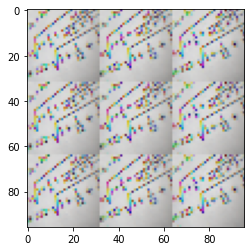

In [159]:
f,profilephoto=resize_image('/content/','ProfilePhoto.jpg',96,1,'first')
shutil.move(f,'/content/Face-Recognition/images96/')
profilephoto
import imageio
import matplotlib.pyplot as plt
plt.imshow(profilephoto.reshape(96,96,3))



In [106]:
os.listdir('/content/')

['.config', 'Face-Recognition', 'gdrive', 'ProfilePhoto.jpg', 'sample_data']

In [163]:
verify("/content/Face-Recognition/images96/ProfilePhoto.jpg",list(database.keys())[1], database, FRmodel)

It's not Bernhard-Riemann, please have to continue studying


(0.9552324, False)

FACE RECOGNITION

In [0]:
! cp /content/gdrive/My\ Drive/Face-Recognition/images/Euclid.jpg /content/

In [0]:
f,euclides=resize_image('/content','Euclid.jpg',96,1,'first')
shutil.move(f,path_new)


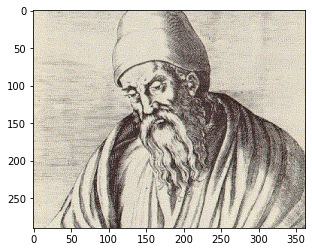

In [173]:
plt.imshow(io.imread('/content/Euclid.jpg'))

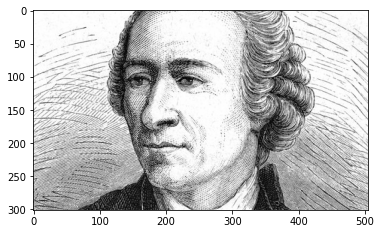

In [196]:
plt.imshow(io.imread(path + 'Euler.jpg'))

In [0]:
path_list.append("images96/" + f)

In [181]:
path_list.pop(path_list.index('/images96Euclid.jpg'))

'/images96Euclid.jpg'

In [0]:
path_list.remove('/images96/Euclid.jpg')

In [190]:
path_list[-5:]

['images96/Aryabhatta.jpg',
 'images96/mary-cartwright.jpg',
 'images96/maryam-mirazakhani.jpg',
 'images96/sophie-germain.jpg',
 'images96/Euclid.jpg']

In [0]:
database=load_database(path_list,FRmodel)

In [204]:
len(list(database.keys()))

61

In [0]:
# GRADED FUNCTION: who_is_it

def who_is_it(image_path, database, model):
    """
    Implements face recognition for the Famous Mathematicians Museum by finding who is the person on the image_path image.
    
    Arguments:
    image_path -- path to an image
    database -- database containing image encodings along with the name of the person on the image
    model -- your Inception model instance in Keras
    
    Returns:
    min_dist -- the minimum distance between image_path encoding and the encodings from the database
    identity -- string, the name prediction for the person on image_path
    """

    encoding = img_to_encoding(image_path,model)    
    min_dist = 100
    
    for (name, db_enc) in database.items():
        dist = np.linalg.norm(encoding-db_enc)
        
        if dist<min_dist:
            min_dist = dist
            identity = name
    
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

Put the picture of him ("images/Euclid.jpg"). Let's see if your who_it_is() algorithm identifies Euclid. 

In [205]:
who_is_it("images96/Euclid.jpg", database, FRmodel)

it's Euclid, the distance is 0.0


(0.0, 'Euclid')

In [206]:
who_is_it("images96/Euler.jpg", database, FRmodel)

it's Euler, the distance is 0.0


(0.0, 'Euler')

You've now seen how a state-of-the-art face recognition system works.

Although we won't implement it here, here're some ways to further improve the algorithm:
- Put more images of each person (under different lighting conditions, taken on different days, etc.) into the database. Then given a new image, compare the new face to multiple pictures of the person. This would increae accuracy.
- Crop the images to just contain the face, and less of the "border" region around the face. This preprocessing removes some of the irrelevant pixels around the face, and also makes the algorithm more robust.


<font color='blue'>
**What you should remember**:
- Face verification solves an easier 1:1 matching problem; face recognition addresses a harder 1:K matching problem. 
- The triplet loss is an effective loss function for training a neural network to learn an encoding of a face image.
- The same encoding can be used for verification and recognition. Measuring distances between two images' encodings allows you to determine whether they are pictures of the same person. 

### References:

- Florian Schroff, Dmitry Kalenichenko, James Philbin (2015). [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/pdf/1503.03832.pdf)
- Yaniv Taigman, Ming Yang, Marc'Aurelio Ranzato, Lior Wolf (2014). [DeepFace: Closing the gap to human-level performance in face verification](https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf) 
- The pretrained model we use is inspired by Victor Sy Wang's implementation and was loaded using his code: https://github.com/iwantooxxoox/Keras-OpenFace.
- Our implementation also took a lot of inspiration from the official FaceNet github repository: https://github.com/davidsandberg/facenet 
